CHATBOT


In [7]:
!pip install python-dotenv langchain[groq]
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 22.2 MB/s eta 0:00:00


In [9]:
from google.colab import userdata
import os

os.environ['GROQ_API_KEY'] = userdata.get('groqAPIKey')

In [14]:
os.environ["LANGCHAIN_API_KEY"] = userdata.get('lanchainKey')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "GenAI"

In [15]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

In [16]:
content=llm.invoke("What is langchain in one sentence")
content=content.content
print(content)

LangChain is an open-source AI framework that enables users to build, train, and deploy large language models (LLMs) for various applications, such as natural language processing, text generation, and conversational AI.


In [17]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [18]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [19]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

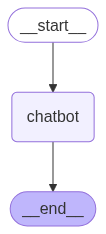

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: who is president of India?
Assistant: As of 2023, the President of India is Droupadi Murmu. She is the 15th President of India and took office on July 25, 2022.
User: what is her age?
Assistant: I apologize, but I don't have any information about a specific "her" and therefore, I don't know her age. Could you provide more context or clarify who "her" refers to?
User: q
Goodbye!


#Memory Saver


In [22]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [23]:
graph = graph_builder.compile(checkpointer=memory)

In [24]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, {"configurable": {"thread_id": "1"}}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: who is the president of India?
Assistant: As of now, the President of India is Droupadi Murmu. She was inaugurated as the 15th President of India on July 25, 2022.
User: what is her age?
Assistant: Droupadi Murmu, the current President of India, was born on June 20, 1958, which makes her 64 years old as of June 2022.
User: q
Goodbye!


#Add tools to websearch


In [25]:
os.environ["TAVILY_API_KEY"] = userdata.get('tavilyKey')

In [27]:
!pip install langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.9 MB/s eta 0:00:00


[{'title': "DeepSeek's release of an open-weight frontier AI model",
  'url': 'https://www.iiss.org/publications/strategic-comments/2025/04/deepseeks-release-of-an-open-weight-frontier-ai-model/',
  'content': 'On 20 January 2025, coincident with the inauguration of United States President Donald Trump, the Chinese company DeepSeek released its ‘R1’ reasoning large language model (LLM). The model’s impressive performance – nearly on par with the world’s most expensive and best-performing models – and the lower training costs incurred during development generated vigorous debate about whether China had closed the gap with the US on artificial intelligence (AI), which Washington seeks to preserve and [...] DeepSeek’s release of an open-weight frontier AI model\n======================================================\n\nThe January 2025 release of a frontier reasoning large language model by the Chinese firm DeepSeek, nearly matching the performance of top American closed models at a fract

In [28]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

tool.invoke("Tell me about deepseek llm launched in jan 2025")

[{'title': "DeepSeek's release of an open-weight frontier AI model",
  'url': 'https://www.iiss.org/publications/strategic-comments/2025/04/deepseeks-release-of-an-open-weight-frontier-ai-model/',
  'content': 'On 20 January 2025, coincident with the inauguration of United States President Donald Trump, the Chinese company DeepSeek released its ‘R1’ reasoning large language model (LLM). The model’s impressive performance – nearly on par with the world’s most expensive and best-performing models – and the lower training costs incurred during development generated vigorous debate about whether China had closed the gap with the US on artificial intelligence (AI), which Washington seeks to preserve and [...] DeepSeek’s release of an open-weight frontier AI model\n======================================================\n\nThe January 2025 release of a frontier reasoning large language model by the Chinese firm DeepSeek, nearly matching the performance of top American closed models at a fract

#ChatBot with memory and web search Tool

In [29]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [30]:
graph = graph_builder.compile(checkpointer=memory)

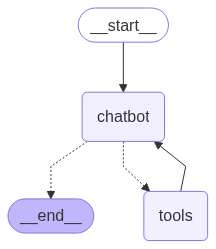

In [31]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [34]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, {"configurable": {"thread_id": "4"}}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: is bellrina movie released?
Assistant: 
Assistant: [{"title": "Belina (Video 2019) - IMDb", "url": "https://www.imdb.com/title/tt11242142/", "content": "![](//fls-na.amazon.com/1/batch/1/OP/A1EVAM02EL8SFB:131-7149554-6470618:DNHN9DQWAFJN7VZT1A68$uedata=s:%2Fuedata%2Fuedata%3Fstaticb%26id%3DDNHN9DQWAFJN7VZT1A68:0)\n\n# Belina\n\n![Belina (2019)](https://m.media-amazon.com/images/M/MV5BNGU4NmIyZjMtOTUxMC00NTNkLWI5ZDctOTM3ODQ2ZmMzYzgwXkEyXkFqcGc@._V1_QL75_UY281_CR5,0,190,281_.jpg) [...] ![Get the IMDb app](https://m.media-amazon.com/images/G/01/IMDb/Mobile/DesktopQRCode-png.png)\n\n© 1990-2025 by IMDb.com, Inc.\n\n![](//fls-na.amazon.com/1/batch/1/OP/A1EVAM02EL8SFB:131-7149554-6470618:DNHN9DQWAFJN7VZT1A68$uedata=s:%2Fuedata%2Fuedata%3Fnoscript%26id%3DDNHN9DQWAFJN7VZT1A68:0) [...] all](/title/tt11242142/plotsummary/?ref_=tt_ov_pl)", "score": 0.52086246}, {"title": "Bellina Logan: Movies, TV, and Bio - Amazon.com", "url": "https://www.amazon.com/prime-video/actor/Bellina-Logan/amzn1.d